In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# SPDX-License-Identifier: CC-BY-4.0
#
# Code for "Bayesian continual learning and forgetting in neural networks"
# Djohan Bonnet, Kellian Cottart, Tifenn Hirtzlin, Tarcisius Januel, Thomas Dalgaty, Elisa Vianello, Damien Querlioz
# arXiv: 2504.13569
# Portions of the code are adapted from the Pytorch project (BSD-3-Clause)
#
# Author: Kellian Cottart <kellian.cottart@gmail.com>
# Date: 2025-07-03

In [22]:

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os
import seaborn as sns
import re
import json
import pandas as pd
AXESSIZE = 28
FONTSIZE = 26
TICKSIZE = 24   
LEGENDSIZE = 26
plt.rcParams['svg.fonttype'] = 'none'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.05"
FOLDER = "output-figures"
os.makedirs(FOLDER, exist_ok=True)
results_folder = "RESULTS-PRESYNAPTIC"
df = pd.DataFrame()
# iterate through all root folders in the results folder
for folder in os.listdir(results_folder):
    current_path = os.path.join(results_folder, folder)
    # extract the name from the first config
    config_path = os.path.join(current_path, "config0/config.json")
    with open(config_path, "r") as f:
        config = json.load(f)
    # n_iterations is the number of config folders
    n_iterations = len([f for f in os.listdir(current_path) if f.startswith("config") and os.path.isdir(os.path.join(current_path, f))])
    
    # Add the row of parameters to the dataframe   
    row = {
        "path": current_path,
        "opt": config["optimizer"] + " N=" + str(config["optimizer_params"]["N"]) if "mesu" in config["optimizer"] else config["optimizer"],
        "layers": int(config["network_params"]["layers"][:-1][1:][0]),
        "n_tasks": config["n_tasks"],
        "n_epochs": config["epochs"],
        "n_train_samples": config["n_train_samples"],
        "n_test_samples": config["n_test_samples"],
        "n_iterations": n_iterations,
    }
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
# One color for each path
colors = sns.color_palette("viridis", len(df["path"].unique()))
markers = ["D", "o", "s", "h", "^", "x", "v", "p", "*", "X", "D", "o", "s", "h", "^", "x", "v", "p", "*", "X"]

In [23]:
data = []
for idx, row in df.iterrows():
    path = row["path"]
    n_tasks = row["n_tasks"]
    n_epochs = row["n_epochs"]
    n_iterations = row["n_iterations"]
    full_accuracies = []
    for it in range(n_iterations):
        current_it_path = os.path.join(path, f"config{it}")
        accuracy_path = os.path.join(current_it_path, "accuracy")
        uncertainty_path = os.path.join(current_it_path, "uncertainty")
        accuracies = []
        for task in range(n_tasks):
            for epoch in range(n_epochs):
                suffix = f"task={task}-epoch={epoch}.npy"
                accuracies.append(jnp.load(os.path.join(accuracy_path, suffix)))
        full_accuracies.append(jnp.array(accuracies)) 
    full_accuracies = jnp.array(full_accuracies)
    accuracy_array = jnp.mean(full_accuracies, 0)[-1].mean()
    accuracy_std = jnp.std(full_accuracies, 0)[-1].mean()
    data.append((accuracy_array, accuracy_std))

# Add new columns to df
df["accuracies"] = [d[0] for d in data]
df["accuracies_std"] = [d[1] for d in data]

In [24]:
df

,path,opt,layers,n_tasks,n_epochs,n_train_samples,n_test_samples,n_iterations,accuracies,accuracies_std
0,RESULTS-PRESYNAPTIC/20250618-122512-permutedmn...,foovbdiagonal,200,10,10,10,10,5,0.9076522,0.018622903
1,RESULTS-PRESYNAPTIC/20250704-190454-permutedmn...,mesu N=5800000,200,10,10,10,10,5,0.9233834,0.011768335


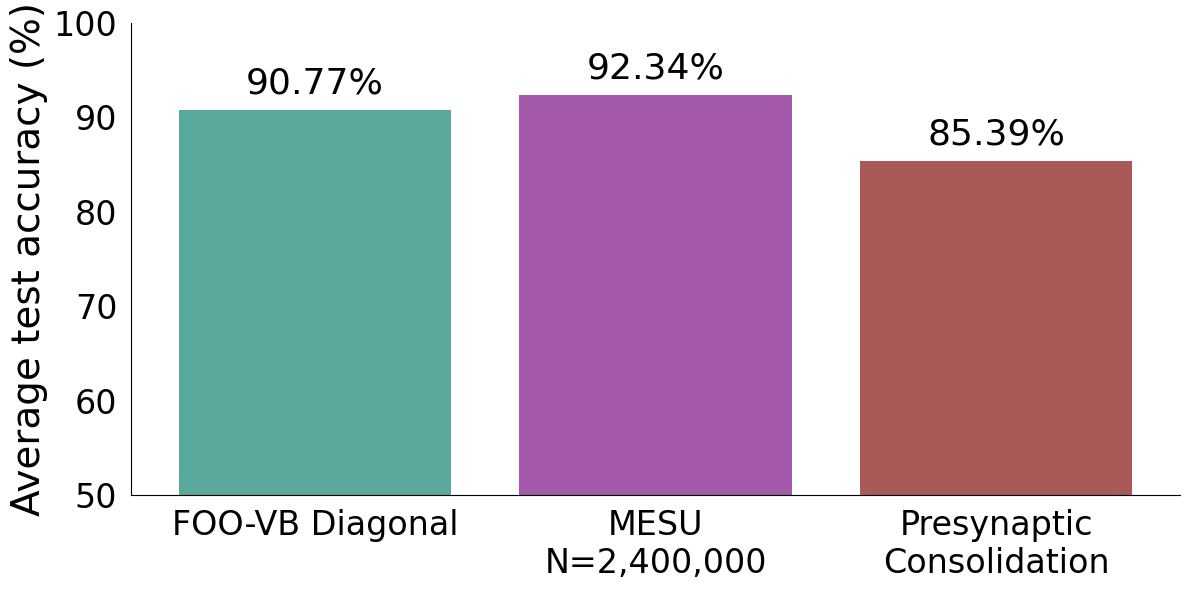

In [25]:
# We're gonna make a barplot of the mean accuracy for each method
text = ["FOO-VB Diagonal", "MESU\nN=2,400,000", "Presynaptic\nConsolidation"]
colors = [
    "#59a89c", #FOO-VB Diagonal
    "#a559aa", #MESU
    "#aa5959", #Presynaptic Consolidation
    
]
fig, ax = plt.subplots(figsize=(12, 6))
for idx, row in df.iterrows():
    accuracies = row["accuracies"] * 100
    ax.bar(text[idx], accuracies, label=row["opt"], color=colors[idx])
    if row["opt"] == "mesu":
        ax.axhline(accuracies, color="black", linestyle="--", linewidth=2)
    ax.text(text[idx], accuracies + 1, f"{accuracies:.2f}%", ha='center', va='bottom', fontsize=FONTSIZE, color='black')
# add reference
ax.bar(text[-1], 85.39, color=colors[-1])
ax.text(text[-1], 85.39 + 1, "85.39%", ha='center', va='bottom', fontsize=FONTSIZE, color='black')
ax.set_ylabel("Average test accuracy (%)", fontsize=AXESSIZE)
plt.xticks(fontsize=TICKSIZE)
plt.yticks(fontsize=TICKSIZE)
ax.set_ylim(50, 100)
ax.tick_params(axis='both', which='both', labelsize=TICKSIZE, length=0, pad=10)
# remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# save the figure
plt.tight_layout()
plt.savefig(os.path.join(FOLDER, "presynaptic-accuracy.svg"), format="svg", dpi=300)
plt.savefig(os.path.join(FOLDER, "presynaptic-accuracy.pdf"), format="pdf", dpi=300)
    